In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [52]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import distributions as dist
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms as tr
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from pprint import pprint
from inpainting.custom_layers import Reshape
from inpainting.inpainters.mnist import MNISTLinearInpainter, MNISTConvolutionalInpainter
from pathlib import Path
import pickle

from inpainting.losses import (
    _nll_masked_batch_loss,
    _batch_loss_fn, 
    _nll_masked_sample_loss_v2, 
    _nll_masked_ubervectorized_batch_loss_v1, 
    nll_masked_batch_loss_same_size_masks, 
    nll_masked_batch_loss,
    _nll_masked_sample_loss_v0,
)
from collections import defaultdict
import time

In [36]:
from inpainting.datasets.mnist import train_val_datasets
from inpainting.visualizations.digits import digit_with_mask as vis_digit_mask
from inpainting.training import train_inpainter
from inpainting.utils import classifier_experiment, inpainted
import inpainting.visualizations.samples as vis
from inpainting.datasets import mask_coding as mc
from inpainting.datasets.utils import RandomRectangleMaskConfig
import pandas as pd
import seaborn as sns

In [5]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = "white"

In [6]:
!ps aux | grep mprzewie

mprzewi+  5640  1.6  0.1 2095268 233596 ?      Ssl  15:52   0:02 /home/mprzewiezlikowski/anaconda3/envs/uj/bin/python -m ipykernel_launcher -f /home/mprzewiezlikowski/.local/share/jupyter/runtime/kernel-96d962f9-6a27-4962-a3e5-af4ada6c0f3e.json
mprzewi+  8724  8.7  0.1 2095928 234292 ?      Ssl  15:54   0:02 /home/mprzewiezlikowski/anaconda3/envs/uj/bin/python -m ipykernel_launcher -f /home/mprzewiezlikowski/.local/share/jupyter/runtime/kernel-04b29d8b-3587-4250-9079-0752ecc3982d.json
mprzewi+  9352 30.0  0.0  50024 29776 ?        Ss   15:54   0:00 /home/mprzewiezlikowski/anaconda3/envs/uj/bin/python -m ipykernel_launcher -f /home/mprzewiezlikowski/.local/share/jupyter/runtime/kernel-f49b90a6-5e23-4f64-873d-69bcbaeb46b2.json
mprzewi+  9394  0.0  0.0   4504   848 pts/74   Ss+  15:54   0:00 /bin/sh -c ps aux | grep mprzewie
mprzewi+  9397  0.0  0.0  12916   960 pts/74   S+   15:54   0:00 grep mprzewie
root     32190  0.3  0.0 492800 112364 ?       Ssl  08:10   1:40 /usr/sbin/glusterfs --

In [7]:
!echo $CUDA_VISIBLE_DEVICES
!nvidia-smi

0
Sun Jan 26 15:54:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 61%   78C    P2   296W / 250W |   6963MiB / 11178MiB |     96%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   28C    P2    60W / 250W |      0MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2 

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

In [9]:
experiment_path = Path("../results/mnist/missing_data_10x10")
experiment_path.mkdir(exist_ok=True)

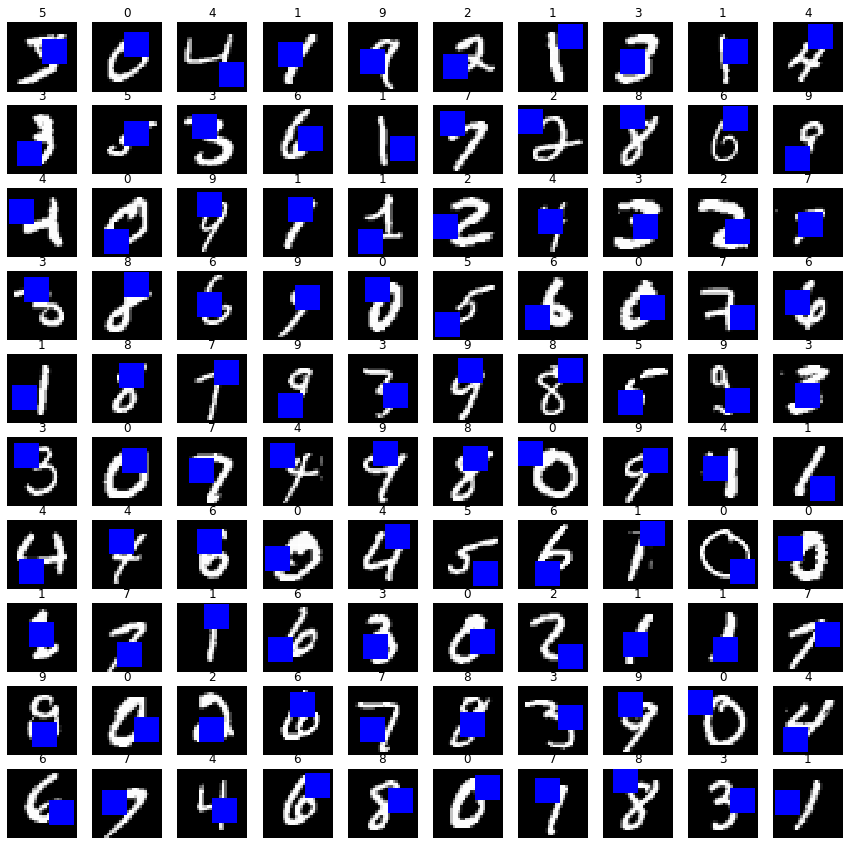

In [27]:
ds_train, ds_val = train_val_datasets(
    "/home/mprzewiezlikowski/uj/data/",
    mask_configs=[
        RandomRectangleMaskConfig(mc.UNKNOWN_LOSS, 10, 10, 0,0),
#         RandomRectangleMaskConfig(mc.UNKNOWN_NO_LOSS, 10,10, 0,0)
    ]
)

fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(100):
    (x,j), y = ds_train[i]
    ax = axes[i // 10, i%10]
    ax.set_title(f"{y}")
    vis_digit_mask(x, j,ax)
train_fig = plt.gcf()
train_fig.savefig(experiment_path / "train.png")
plt.show()

In [28]:
batch_size=96
dl_train = DataLoader(ds_train, batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size, shuffle=True)

In [29]:
m_std = lambda x, j, p, m, a, d: m.std(dim=0).mean()
a_max =  lambda x, j, p, m, a, d: a.max()

In [53]:
losses_to_benchmark = {
    "v0": _batch_loss_fn(_nll_masked_sample_loss_v0),
    "v1": _nll_masked_batch_loss,
    "v2": _batch_loss_fn(_nll_masked_sample_loss_v2),
    "v3": _nll_masked_ubervectorized_batch_loss_v1,
    "v4": nll_masked_batch_loss_same_size_masks,
    "v5": nll_masked_batch_loss
}

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
# device = torch.device("cpu")
history = []
# inpainter = MNISTLinearInpainter(n_mixes=1, hidden_size=2048)
inpainter = MNISTConvolutionalInpainter(n_mixes=1)

opt = optim.Adam(inpainter.parameters(), lr=4e-5, weight_decay=0)
n_epochs = 50
benchmark_results = defaultdict(list)
l_values = defaultdict(list)

inpainter = inpainter.to(device)
inpainter.eval()

for i, ((x,j), y) in tqdm(enumerate(dl_train)):
    x, j, y = [t.to(device) for t in [x, j, y]]
    p, m, a, d = inpainter(x, j)
    
    for loss_name, l in losses_to_benchmark.items():
        s = time.time()
        
        v =  l(x, j, p, m, a, d)#.detach().cpu().numpy()
        e = time.time()
        
        benchmark_results[loss_name].append(e - s)
        l_values[loss_name].append(v)
    
    if i == 10:
        break






0it [00:00, ?it/s]/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)





1it [00:01,  1.87s/it]




2it [00:03,  1.88s/it]




3it [00:05,  1.84s/it]




4it [00:07,  1.82s/it]




5it [00:09,  1.82s/it]




6it [00:10,  1.82s/it]




7it [00:12,  1.86s/it]




8it [00:14,  1.85s/it]




9it [00:16,  1.92s/it]




10it [00:18,  1.93s/it]

In [84]:
df_bench_cpu = pd.DataFrame(benchmark_results)

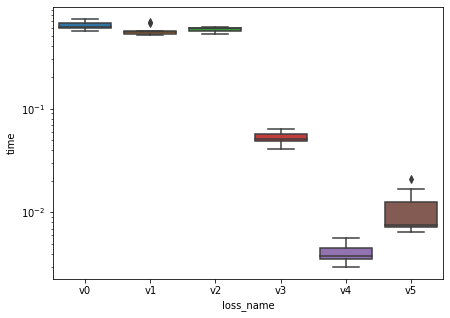

In [86]:
f, ax = plt.subplots(figsize=(7, 5))
ax.set(yscale="log")
sns.boxplot(
    x="loss_name",
    y="time",
    data=pd.melt(df_bench_cpu).rename({"variable": "loss_name", "value": "time"}, axis="columns"), ax=ax
)

In [59]:
l_values

defaultdict(list,
            {'v0': [array(66.583984, dtype=float32),
              array(65.71504, dtype=float32),
              array(65.357285, dtype=float32),
              array(63.096542, dtype=float32),
              array(63.878548, dtype=float32),
              array(62.299873, dtype=float32),
              array(67.037704, dtype=float32),
              array(61.060787, dtype=float32),
              array(63.951977, dtype=float32),
              array(63.74763, dtype=float32),
              array(64.21957, dtype=float32)],
             'v1': [array(79.25442, dtype=float32),
              array(78.8196, dtype=float32),
              array(78.6407, dtype=float32),
              array(77.499084, dtype=float32),
              array(77.90642, dtype=float32),
              array(77.11038, dtype=float32),
              array(79.47891, dtype=float32),
              array(76.489426, dtype=float32),
              array(77.94107, dtype=float32),
              array(77.82483, dtype=float